In [1]:
import torch
import sys
import numpy as np
import matplotlib.pyplot as plt
from typing import Union
import random

In [2]:
#Method to auto intialize params without explicitly declaring them
def save_parameters(obj:object):
  local_params = sys._getframe(1).f_locals
  obj.params = {key:val for key,val in local_params.items() if key not in ["self"] and not key.startswith("_")}
  for key,val in obj.params.items():
    setattr(obj,key,val)

# Function to link new methods to an existing class
def add_to_class(cls):
  def wrapper(obj):
    setattr(cls,obj.__name__,obj)
    return obj
  return wrapper


class DataGen():
  #Generates random linear/quadratic regressor dataset to train the model on
  def __init__(
      self,feats:int=5,reln:str="linear",train_size:int=10000,
      val_size:int=1000,test_size:int=2000,noise:float=0.1,
      w:list=[0.1,0.2,0.3,0.4,0.5],
      b:float=0.5)->None:
    save_parameters(self)
    torch.set_default_dtype(torch.float64)
    self.X = torch.randn(self.train_size+self.val_size+self.test_size,self.feats)
    self.w = torch.tensor(w,requires_grad=True)
    self.b = torch.tensor(b,requires_grad=True)
    self.noise = torch.randn(self.train_size+self.val_size+self.test_size,1)*self.noise
    self.reln = reln

  def __call__(self):
    if self.reln == "quadratic":
      assert self.feats == len(self.w[0]) and len(self.w[1])== self.feats,f"""Default assumption is linear,
              for quadratic input weights should be list of lists of size {feats}"""
      self.y = (X*X)@self.w[0].reshape(-1,1)+X@self.w[1].reshape(-1,1)+self.b+self.noise
    elif self.reln == "linear":
      assert self.feats == len(self.w),f"features size {self.feats} should match size of weights list {len(self.w)}"
      self.y = self.X@self.w.reshape(-1,1)+self.b.reshape(-1,1)+self.noise
    return self.X,self.y

#generator = DataGen(reln="quadratic",w=[[0.1,0.3,0.2,0.5,0.9],[0.6,0.1,3.1,2.6,1.9]])
generator = DataGen(reln="linear",w=[0.8,1.6,4.1,2.2,3.4])
X,y = generator()



In [3]:
train_size=10000
val_size=1000
test_size=2000
train_X,train_y=X[:train_size],y[:train_size]
val_X,val_y=X[train_size:train_size+val_size],y[train_size:train_size+val_size]
test_X,test_y=X[-test_size:],y[-test_size:]


In [4]:
#Method to shuffle,index and generate batches of dataset for training,valisdation
def get_data(X,y,train=True,batch_size=128):
  index = slice(0,train_size) if train else slice(train_size,train_size+val_size)
  indices = list(range(X.shape[0]))
  random.shuffle(indices)
  for b_index in range(0,len(indices),batch_size):
    batch_index = torch.tensor(indices[b_index:b_index+batch_size])
    yield X[batch_index],y[batch_index]

def get_damn(X,y,train=True,batch_size=32):
  index = slice(0,train_size) if train else slice(train_size,train_size+val_size)
  data = zip(X,y)
  indices = list(range(X.shape[0]))
  random.shuffle(indices)
  for b_index in range(0,len(indices),batch_size):
    batch_index = torch.tensor(indices[b_index:b_index+batch_size])
    yield X



In [31]:

class Regressor():
  def __init__(self,batch_size=64,lr=0.0001):
    save_parameters(self)

  def forward(self,X):
    return X@self.w.reshape(-1,1)+self.b.reshape(-1,1)

  def train(self):
    raise NotImplemented

  def optimizer(self,batch_y,y_hat,batch_X):
    self.w = self.w - torch.mean(self.lr*(y_hat-batch_y)*batch_X,dim=0)
    self.b = self.b - self.lr*torch.mean((y_hat-batch_y),dim=0)

  def loss(self,batch_y,y_hat):
    return torch.mean((y_hat-batch_y)**2)*0.5

  
  def fit(self):
    self.w = torch.randn(1,X.shape[1])
    self.b = torch.randn(1)
    self.w.requires_grad=False
    self.b.requires_grad=False
    losses = []
    n_batches = train_size/self.batch_size
    n_val_batches = val_size/self.batch_size
    for epoch in range(500): #Used 500 epochs to demonstrate the global minina of the dataset
      train_loss,val_loss=0,0
      print(f"Epoch {epoch} running ..")
      for train_X,train_y in get_data(X,y.detach()):
        train_y.requires_grad=False
        y_pred = self.forward(train_X)
        batch_loss=self.loss(train_y,y_pred)
        self.optimizer(train_y,y_pred,train_X)
        train_loss+=batch_loss
      for val_X,val_y in get_data(X,y,train=False):
        y_val_hat = self.forward(val_X)
        val_loss+=self.loss(val_y,y_val_hat)
      loss = train_loss/n_batches
      val_loss = val_loss/n_val_batches
      losses.append([loss,val_loss])
      print(f"Train loss:{batch_loss},val_loss:{val_loss}")
    return losses

model = Regressor()
loss = model.fit()


Epoch 0 running ..
Train loss:19.005764433639268,val_loss:113.83837831532584
Epoch 1 running ..
Train loss:18.11890160574498,val_loss:111.66074681711456
Epoch 2 running ..
Train loss:13.62164236994581,val_loss:109.27373700183288
Epoch 3 running ..
Train loss:16.058736484514558,val_loss:107.21485208383415
Epoch 4 running ..
Train loss:15.142494466645822,val_loss:104.82558362973612
Epoch 5 running ..
Train loss:15.230062642421792,val_loss:102.70687964097606
Epoch 6 running ..
Train loss:13.516056878264198,val_loss:100.78173983029625
Epoch 7 running ..
Train loss:11.768698669187657,val_loss:98.53885292454808
Epoch 8 running ..
Train loss:14.240982119091788,val_loss:96.57193343272212
Epoch 9 running ..
Train loss:23.27922599775559,val_loss:94.72267642170274
Epoch 10 running ..
Train loss:12.56537320329381,val_loss:92.67702763246184
Epoch 11 running ..
Train loss:13.93808318041983,val_loss:90.79018667603201
Epoch 12 running ..
Train loss:13.610545465023856,val_loss:88.98345642246895
Epoch 1

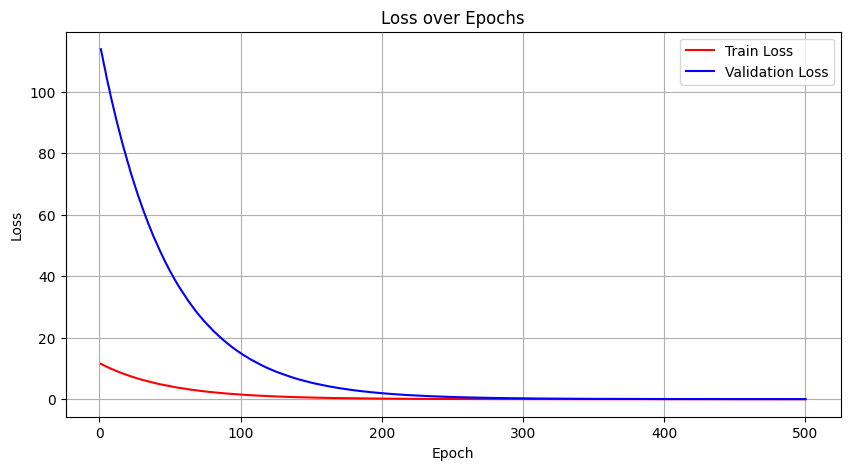

In [33]:
def plot_loss(index, loss, val_loss):
    fig = plt.figure(figsize=(10, 5))
    ax1 = fig.add_subplot(1, 1, 1)
    ax1.plot(index, loss, "r", label="Train Loss")
    ax1.plot(index, val_loss, "b", label="Validation Loss")
    ax1.legend()  # Let matplotlib pull labels from .plot()
    ax1.set_title("Loss over Epochs")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    plt.grid(True)
    plt.show()


train_loss = [i[0].detach() for i in loss]
val_loss = [i[1].detach() for i in loss]
plot_loss(list(range(1,501)),train_loss,val_loss)




In [34]:
#predicts the test set
@add_to_class(Regressor)
def predict(self,X):
  return self.forward(X)

In [35]:
y_pred = []
for data in test_X:
  y_pred.append(model.predict(data))
y_pred = torch.tensor(y_pred).detach()

In [36]:
model.loss(torch.tensor(y_pred).detach(),test_y)

C:\Users\dines\AppData\Local\Temp\ipykernel_38252\3109421418.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.loss(torch.tensor(y_pred).detach(),test_y)


tensor(36.8685, grad_fn=<MulBackward0>)

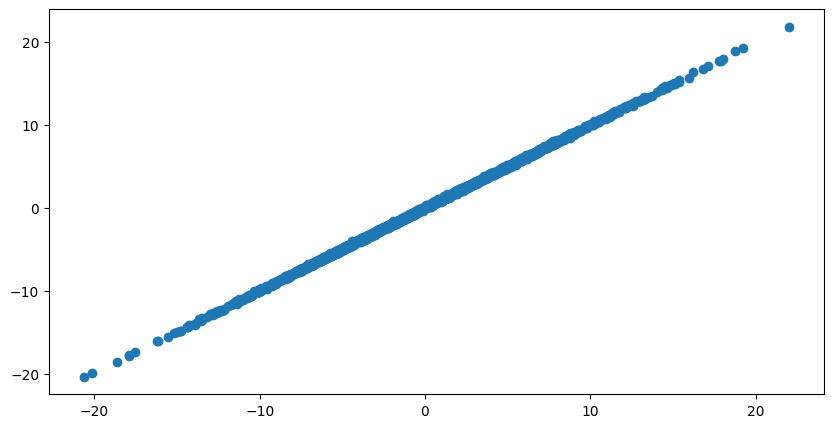

In [37]:
#plot of y_test vs y_pred_test to visualise the fit
fig2 = plt.figure(figsize=(10, 5))
ax2 = fig2.add_subplot(1, 1, 1)
ax2.scatter(test_y.detach(),y_pred)

In [38]:
model.w

tensor([[0.8005, 1.5957, 4.0750, 2.1937, 3.3745]])

In [30]:
[0.8,1.6,4.1,2.2,3.4]

[0.8, 1.6, 4.1, 2.2, 3.4]